In [63]:
import pickle
from inspect_weights import *
from plotting import *


In [130]:
number_base_sequences = 2
number_hidden_units = 1
number_epochs = 250
affix = '_trainsorted'
fname = f'{number_base_sequences}seqs_{number_hidden_units}_{number_epochs}{affix}'

In [131]:
# read in models & losses
d_models = torch.load(f'results/{fname}_modelonly.pt')
config_model = d_models['config_model']

with open(f'results/{fname}_losses.pkl', 'rb') as f:
    data = pickle.load(f)
n_loss, n_epochs, n_sim = data.shape


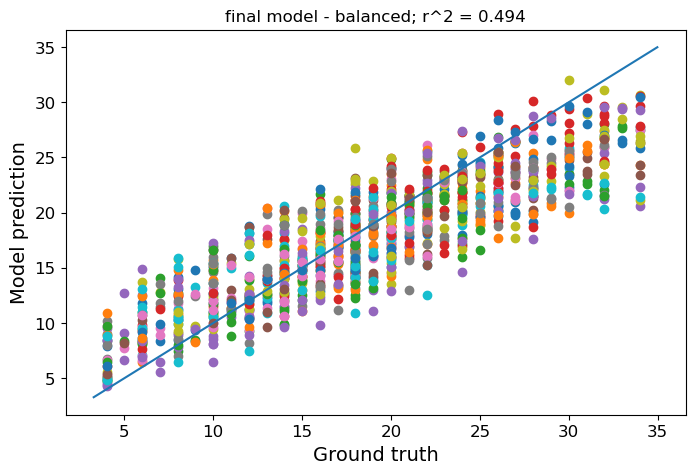

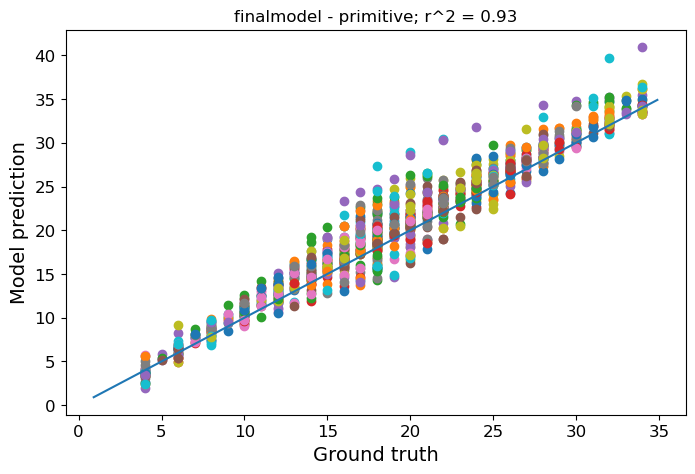

In [132]:
# Complementing 2 base sequences with primitive mappings (Primitive) 
# or 2 additional sequences that result in the same overall frequency per input symbol (Balanced)
# Primitive pre-training results in better performance than Balanced pre-training

plot_predcorr(config_model, fname, d_models['final_mod_b'], d_models['test'], config_model, title = 'final model - ', cond = 'b')
plot_predcorr(config_model, fname, d_models['final_mod_p'], d_models['test'], config_model, title = 'finalmodel - ',  cond = 'p')

Text(0.5, 0.94, 'RNN predictions against ground truth')

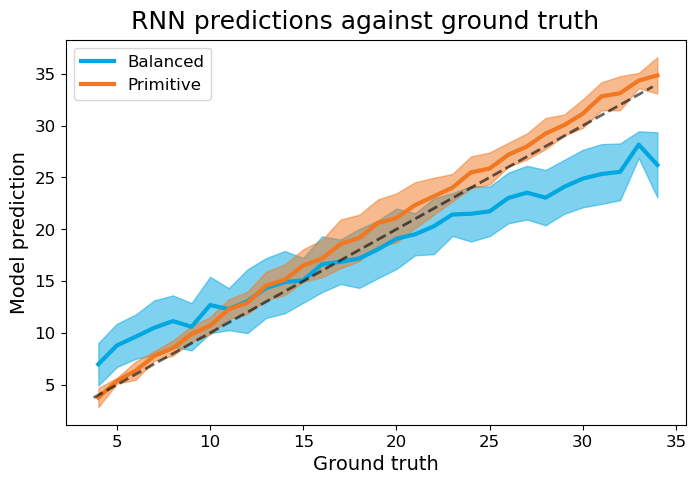

In [133]:
_,_, dfs1b = predcorr(config_model, d_models['final_mod_b'], d_models['test'], config_model['hidden_size'], plot_corr =False)
_,_, dfs1p = predcorr(config_model, d_models['final_mod_p'], d_models['test'], config_model['hidden_size'], plot_corr =False)

all_dfs_p = pd.concat(dfs1p)
all_dfs_b = pd.concat(dfs1b)

labels = ['Balanced', 'Primitive']
plt.rcParams['figure.figsize'] = (8,5)

for i, all_dfs in enumerate([all_dfs_b, all_dfs_p]):
    
    agg_df = all_dfs.groupby(['label']).agg({'pred': ['mean', 'std']})
    yvals = agg_df['pred']['mean']
    yerr = agg_df['pred']['std']
    xvals = agg_df.index
    plt.plot(xvals,yvals, color = bp_colors[i], linewidth=3,label=labels[i])
    plt.fill_between(xvals, yvals - yerr, yvals+yerr, color = bp_colors[i], alpha=0.5)
    xy = np.arange(np.min(yvals),np.max(xvals))
    
plt.plot(xy, xy, color='black', linestyle='dashed',linewidth=2, alpha=0.6)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.legend(loc = 'upper left')
plt.suptitle('RNN predictions against ground truth', y=0.94)

## The better in2hid weights mirror ground truth values, the better model performance

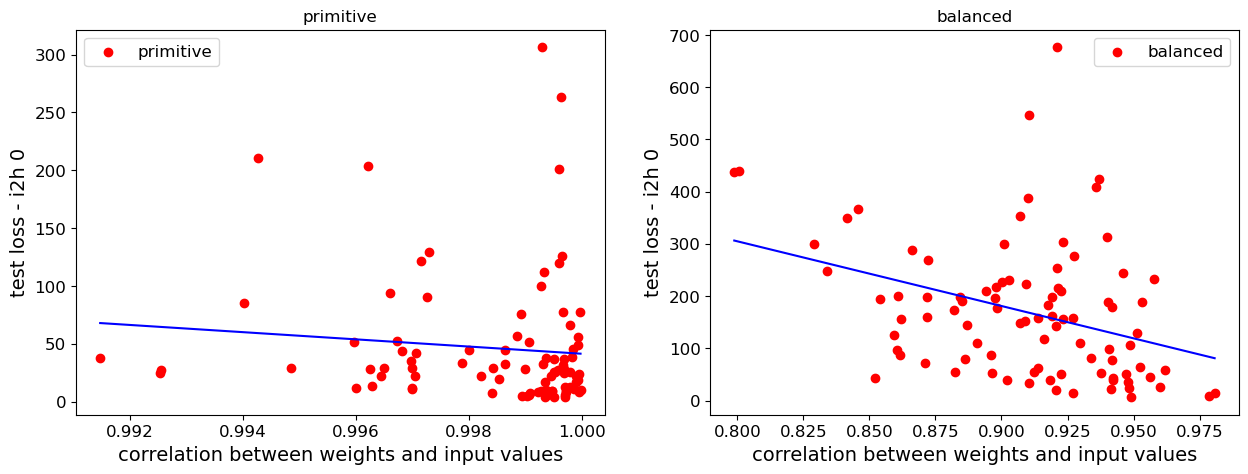

In [135]:
n_hid = d_models['config_model']['hidden_size']
n_hid = np.min([5,n_hid])

fig, axs = plt.subplots(n_hid, 2, figsize=(15, 5))
if len(axs.shape)==1:
    axs = [axs]

for i,ax_x in enumerate(axs):
    if not hasattr(ax_x, "__iter__"):
            ax_x = [ax_x]

    # correlation between weights and input values for converged model weights, is on average higher for primitive compared to balanced models
    # suggesting that the balanced model relies on the bias term to push towards the correct solution (this solution won't extrapolate well)
    corr_p, corr_b = corr_weights2hidden_inputs(d_models, n_unit=i, verbose=False)
    # get indices of 3 smallest outliers
    outliers_p = np.where(corr_p < np.mean(corr_p) - np.std(corr_p))[0][:10]
    outliers_b = np.where(corr_b < np.mean(corr_b) - np.std(corr_b))[0][:10]


    # loop through each subplot and condition
    for ax, cond, corr, outlier in zip(ax_x,['primitive','balanced'],[corr_p,corr_b],[outliers_p,outliers_b]):
        
        test_loss = data.sel(loss_type=f'test_loss_{cond[0]}',  epoch=n_epochs-1).to_numpy()
 
        #exclude outliers
        test_loss = np.delete(test_loss, outlier)
        corr = np.delete(corr, outlier)

        #exclude most extreme values

        ax.scatter(corr, test_loss
                , color='red', label=cond)
        
        # add regression line through scatterplot

        ax.plot(np.unique(corr), np.poly1d(np.polyfit(corr, test_loss, 1))(np.unique(corr)), color='blue')
        ax.set_xlabel('correlation between weights and input values')
        ax.set_ylabel(f'test loss - i2h {i}')
        ax.set_title(cond)
        ax.legend()

In [112]:
def get_hidden_reps(models, config, mod_names = 'final_mod'):
    n_sequence_steps = 5

    rdms = [[] for _ in range(n_sequence_steps)]
    for i_sim in range(len(models[mod_names])):
        #reinstantiate the model with the weights
        state_dict = models[mod_names][i_sim]
        model = OneStepRNN(config['input_size'], config['output_size'], 
                        config['hidden_size'], config['num_layers'], config['xavier_gain'])
        model.load_state_dict(state_dict)

        # change testsequence labels to fit each model's dict
        new_testseqs = []
        for datset in [models['train_b'][0].dataset, models['test'][0].dataset]:
            datset.recompute_label(models['cue_dict'][i_sim])
            datset.sort_by_label(sort='asc')
            new_testseqs.append(datset)

        testset = torch.utils.data.ConcatDataset(new_testseqs)
        testset = DataLoader(testset, batch_size=1, shuffle=False)
        
        # get activations for primitive trained model
        hiddens_p, _ = get_reps(model, [testset], config['hidden_size']) 

        #compute distance matrix
        for h in range(n_sequence_steps): #5 steps in sequence
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms[h].append(rep_mat)

    matlist = [np.array(d).mean(axis = 0) for d in rdms] #average over models

    return rdms,matlist, testset


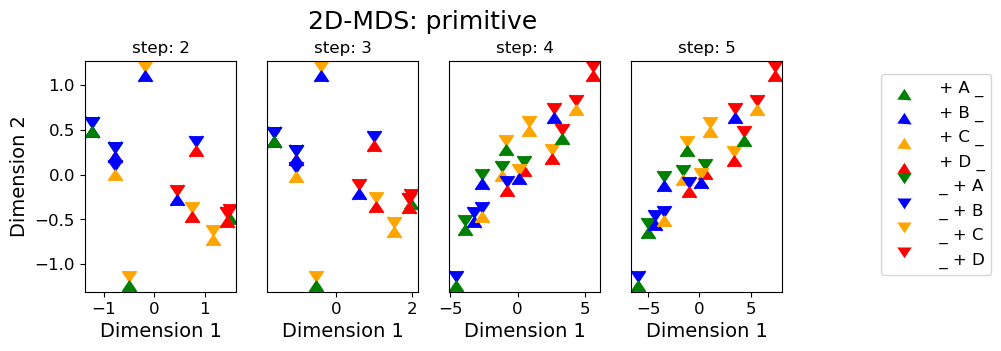

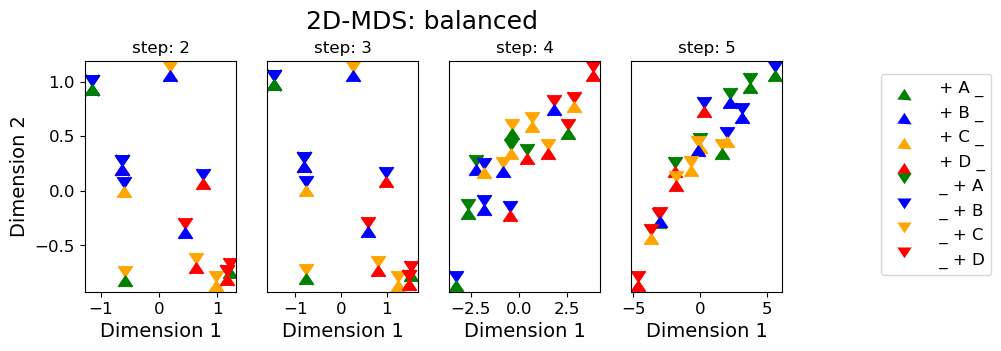

In [20]:
# In terms of geometry of the hidden unit activations
# After primitive pre-training the representation if more grid-like compared to balanced pre-training
dms_p, matlist, testset = get_hidden_reps(d_models, config_model, 'final_mod_p')
MDS_plot(fname, matlist, testset, [], rand_state=48, affix='p')
    
dms_b, matlist, testset = get_hidden_reps(d_models, config_model, 'final_mod_b')
MDS_plot(fname, matlist, testset, [], rand_state=48, affix = 'b')


In [21]:
t=2
all_dists_p = []
for dm in dms_p[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3]/dm[j, 12+j])
    
    all_dists_p.append(dists)

all_dists_b = []
for dm in dms_b[t]:
    dists = []
    for j in range(4):
        dists.append(dm[4*j,4*j+3]/dm[j, 12+j])
    all_dists_b.append(dists)

totdata = np.append(np.array(all_dists_b).flatten(), np.array(all_dists_p).flatten())
kind_data = np.repeat(['Balanced', 'Primitive'], len(np.array(all_dists_b).flatten()))
df = pd.DataFrame({'Distance':totdata, 'Curriculum':kind_data})

In [22]:
inf_columns = df.columns[df.isin([np.inf]).any()]
df = df[~df[inf_columns].isin([np.inf]).any(axis=1)]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Balanced v.s. Primitive: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.564e-21 stat=5.374e+03


(<AxesSubplot:xlabel='Curriculum', ylabel='Addend / Augend span ratio'>,
 [<statannot.StatResult.StatResult at 0x7fe602c81e10>])

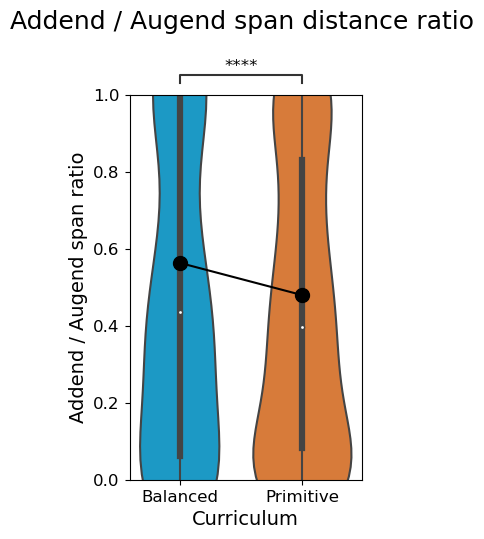

In [23]:
import statannot
fig, ax = plt.subplots(figsize=(3,5))
sns.violinplot(data=df, x='Curriculum', y='Distance', palette=bp_pal, capsize=0.1, ax = ax)
mean_y = [np.mean(np.array(all_dists_b).flatten()),np.mean(np.array(all_dists_p).flatten())] 
ax.plot([0,1], mean_y, marker="o", markersize=10, color='black')
ax.set_ylabel('Addend / Augend span ratio')
ax.set_ylim(0,1)

plt.suptitle('Addend / Augend span distance ratio', y=1.05)

statannot.add_stat_annotation(
    ax=ax,
    data=df,
    x='Curriculum',
    y='Distance',
    box_pairs=[('Balanced','Primitive')],
    test="Wilcoxon",
    text_format="star",
    loc='outside')

In [104]:
##
# "At low numbers of base training sequences, the Primitive group performed significantly better than the Balanced"
#plot_rmse_setsize(fname)

def get_ground_truth_correlation(models, config, cond = 'final_mod_b'):
    all_r2 = []
    n_sims = len(models[cond])
    for ix, model_dict in enumerate(models[cond]):
        model = OneStepRNN(config['input_size'], config['output_size'], 
                        config['hidden_size'], config['num_layers'], config['xavier_gain'])
        model.load_state_dict(model_dict)

        df = test_preds(model, [models['test'][ix]], config['hidden_size'])
        all_r2.append(r2_score(df['pred'],df['label']))

    r2_mean = np.mean(all_r2)
    r2_sterr = np.std(all_r2)/math.sqrt(n_sims)

    return r2_mean, r2_sterr

vals = np.empty((0,4))
for len_seq in range(1,5):

    #load model
    tmp_name = f'{len_seq}{fname[1:]}'
    print(tmp_name)
    tmp_models = torch.load(f'results/{tmp_name}_modelonly.pt')
    config = tmp_models['config_model']

    #correlate predictions with gorund truth
    r2_b, sterr_b = get_ground_truth_correlation(tmp_models, config, cond = 'final_mod_b')
    r2_p, sterr_p = get_ground_truth_correlation(tmp_models, config, cond = 'final_mod_p')

    #collect across set sizes
    set_vals = [r2_b, r2_p, sterr_b, sterr_p]
    vals = np.vstack([vals, set_vals])

#plot
j = 0
labels = ['Balanced','Primitive']
colors = ['#00A7E1', '#F17720']
plt.figure(figsize = (7,3))
xpos = np.arange(1, vals.shape[0]+1)
Nn = int(vals.shape[1]/2)
for j in range(Nn):
    plt.plot(xpos, vals[:,j], label = labels[j], color=colors[j])
    plt.fill_between(xpos, vals[:,j] + vals[:,j+Nn], vals[:,j] - vals[:,j+Nn], color=colors[j], alpha=0.2)
plt.legend(loc='lower right')
plt.xlabel('Base training trials')
plt.ylabel('$R^2$')
plt.title('Prediction $R^2$ against number of base training trails')
plt.show()

1seqs_2_1000
2seqs_2_1000
3seqs_2_1000
4seqs_2_1000


FileNotFoundError: [Errno 2] No such file or directory: 'results/4seqs_2_1000_modelonly.pt'